# Temperature in B-SOSE: compute fronts

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [3]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [60]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [61]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in bsose_files[:5]])


First 5 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc']


In [62]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in bsose_files[:5]])

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
theta_file = bsose_path / 'Theta_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'

print(f'\nfile to open --> {MLD_file.name}')
print(f'\nfile to open --> {theta_file.name}')
print(f'\nfile to open --> {grid_file.name}')


First 5 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc']

file to open --> MLD_bsoseI156_2013to2024_monthly.nc

file to open --> Theta_bsoseI156_2013to2024_monthly.nc

file to open --> grid.nc


In [63]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
ds = xr.open_dataset(theta_file)
MLD_ds = xr.open_dataset(MLD_file)
grid_ds = xr.open_dataset(grid_file)

# stop timer
total_time = time.time() - start_time

print('\nloaded theta')
print(f'total time {total_time:.2f} sec')
print('time level : ' , ds.time.values[0])

# show contents of single granule
ds


loaded theta
total time 0.15 sec
time level :  2013-01-30T20:00:00.000000000


<xarray.Dataset> Size: 38GB
Dimensions:  (time: 144, XC: 2160, YC: 588, Z: 52)
Coordinates: (12/14)
    iter     (time) int64 1kB ...
  * time     (time) datetime64[ns] 1kB 2013-01-30T20:00:00 ... 2024-12-28T10:...
  * XC       (XC) float32 9kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC       (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 208B -2.1 -6.7 -12.15 ... -5e+03 -5.4e+03 -5.8e+03
    rA       (YC, XC) float32 5MB ...
    ...       ...
    hFacC    (Z, YC, XC) float32 264MB ...
    maskC    (Z, YC, XC) bool 66MB ...
    maskInC  (YC, XC) bool 1MB ...
    rhoRef   (Z) float32 208B ...
    rSurfC   (YC, XC) float32 5MB ...
    rLowC    (YC, XC) float32 5MB ...
Data variables:
    THETA    (time, Z, YC, XC) float32 38GB ...

### SST at fixed month

In [64]:
# SST for specific month
st = time.time()

ti = 7
theta_ti = ds.THETA.isel(time=ti)
SST_ti = np.where(ds.maskC.isel(Z=0),theta_ti.isel(Z=0),np.nan)

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')

total time to compute the mean temperature 0.0273s


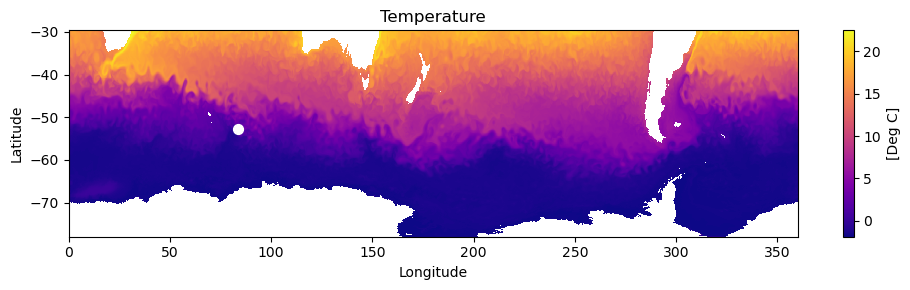

In [69]:
plt.figure(figsize=(10, 3))

var = SST_ti

plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='plasma')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature')
plt.tight_layout()

x_point = ds.XC[500]
y_point = ds.YC[400]
plt.scatter(x_point, y_point, color='white', s=50, marker='o', label='Station A')

plt.show()

In [67]:
# Find frontal regions for SST

# Get x and y coordinate arrays
x = ds.XC.values  # shape (nx,)
y = ds.YC.values  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SST gradient
dSST_dx = np.gradient(SST_ti, axis=1) / DX
dSST_dy = np.gradient(SST_ti, axis=0) / DY

# Gradient magnitude
grad_SST = np.sqrt(dSST_dx**2 + dSST_dy**2)

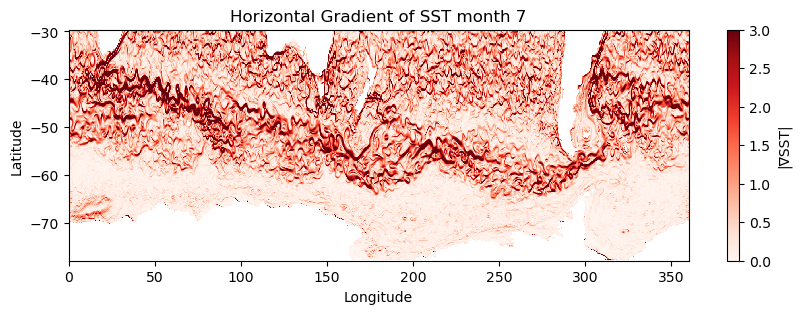

In [70]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SST, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of SST month {ti}')

plt.show()

### Monthly MLD and SST

In [71]:
# Monthly MLD

MLD = np.full((MLD_ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    mxdlayer = MLD_ds.BLGMLD.isel(time=ti)
    MLD[ti] = np.where(MLD_ds.maskInC,mxdlayer,np.nan)

/tmp/ipykernel_50/2535341092.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  MLD = np.full((MLD_ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_50/2535341092.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


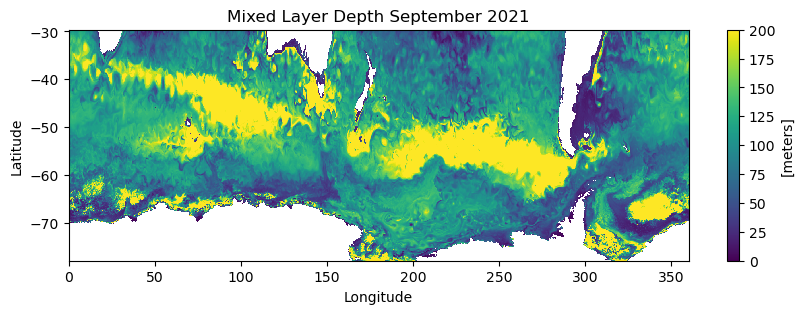

In [73]:
# XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97 # feb 2021
ti=104 # sept 2021
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin = 0
vmax = 200
plt.pcolormesh(XCc, YCc, MLD[ti,:,:], shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar(label='[meters]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mixed Layer Depth {time_str}')

plt.show()

In [74]:
# Monthly SST
st = time.time()

SST = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    theta = ds.THETA.isel(time=ti)
    SST[ti] = np.where(ds.maskC.isel(Z=0),theta.isel(Z=0),np.nan)

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')

/tmp/ipykernel_50/38195100.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  SST = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_50/38195100.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


total time to compute the mean temperature 3.08s


In [75]:
# Find frontal regions for SST

# Get x and y coordinate arrays
x = ds.XC  # shape (nx,)
y = ds.YC  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SST gradient
dSST_dx = np.gradient(SST, axis=2) / DX
dSST_dy = np.gradient(SST, axis=1) / DY

# Gradient magnitude
grad_SST = np.sqrt(dSST_dx**2 + dSST_dy**2)

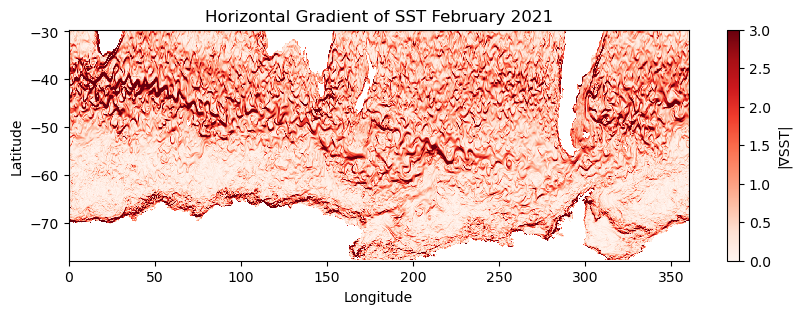

In [77]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SST[ti,:,:], shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of SST {time_str}')

plt.show()

### Time avg SST and MLD

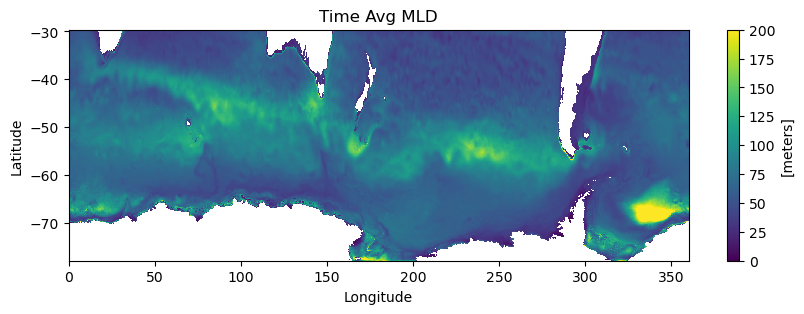

In [78]:
# Time avg SST gradient
MLD_avg = MLD.mean(axis=0)

plt.figure()

vmin = 0
vmax = 200
plt.pcolormesh(XCc, YCc, MLD_avg, shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar(label='[meters]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Time Avg MLD')

plt.show()

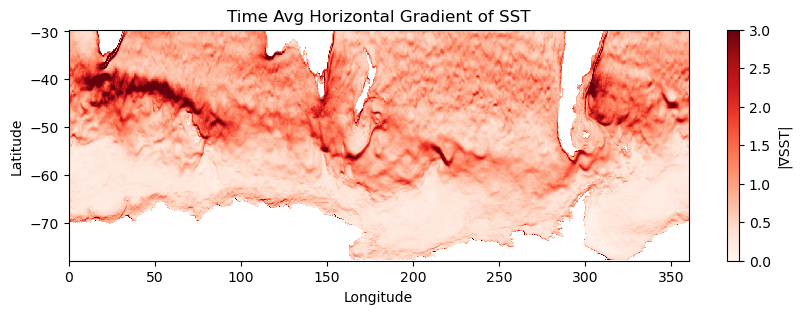

In [79]:
# Time avg SST gradient
grad_SST_avg = grad_SST.mean(axis=0)

plt.figure()

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SST_avg, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Time Avg Horizontal Gradient of SST')

plt.show()

### MLD and SST Climatology

In [80]:
# Create climatology for MLD

# Group by month and compute climatology (mean for each month)
MLD_clim = MLD_ds.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in MLD_clim["month"].values]
MLD_clim = MLD_clim.assign_coords(month=("month", month_names))

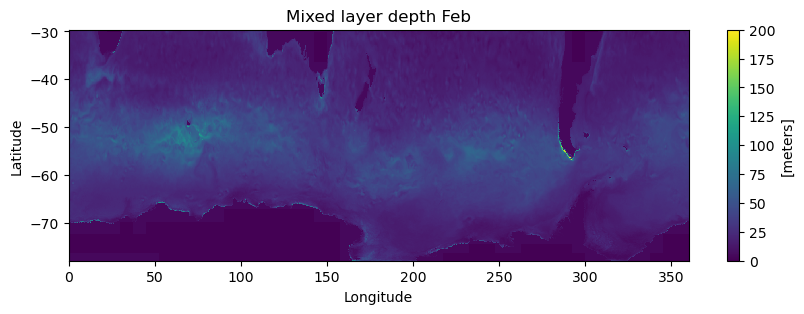

In [94]:
plt.figure()

mm=1
month_str = month_names[mm]

vmin = 0
vmax = 200
plt.pcolormesh(XCc, YCc, MLD_clim['BLGMLD'].isel(month=mm), shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar(label='[meters]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mixed layer depth {month_str}')

plt.show()

In [82]:
# Create climatology for SST

# Wrap gradient array into DataArray
grad_SST_da = xr.DataArray(
    grad_SST,
    coords={"time": ds.time, "YC": ds.YC, "XC": ds.XC},
    dims=["time", "YC", "XC"]
)

# Group by month and compute climatology (mean for each month)
grad_SST_clim = grad_SST_da.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in grad_SST_clim["month"].values]
grad_SST_clim = grad_SST_clim.assign_coords(month=("month", month_names))

In [83]:
grad_SST_clim['month']

<xarray.DataArray 'month' (month: 12)> Size: 144B
array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'], dtype='<U3')
Coordinates:
  * month    (month) <U3 144B 'Jan' 'Feb' 'Mar' 'Apr' ... 'Oct' 'Nov' 'Dec'

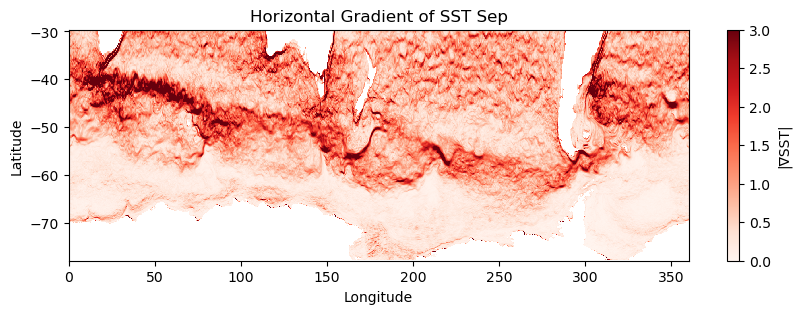

In [84]:
plt.figure()

mm=8
month_str = grad_SST_clim["month"].values[mm]

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, grad_SST_clim[mm,:,:], shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of SST {month_str}')

plt.show()

### ML temperature

In [85]:
theta_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
              
for ti in range(ds.dims['time']):
    MLD_t = MLD_ds.BLGMLD.isel(time=ti)
    theta_t = ds.THETA.isel(time=ti)
    theta_ML_t = np.mean(theta_t.where((-ds.Z<MLD_t)),axis=0)
    theta_ML[ti,:,:] = np.where(ds.maskInC,theta_ML_t,np.nan)

/tmp/ipykernel_50/2097227020.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  theta_ML = np.full((ds.dims['time'],ds.dims['YC'],ds.dims['XC']),np.nan)
/tmp/ipykernel_50/2097227020.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


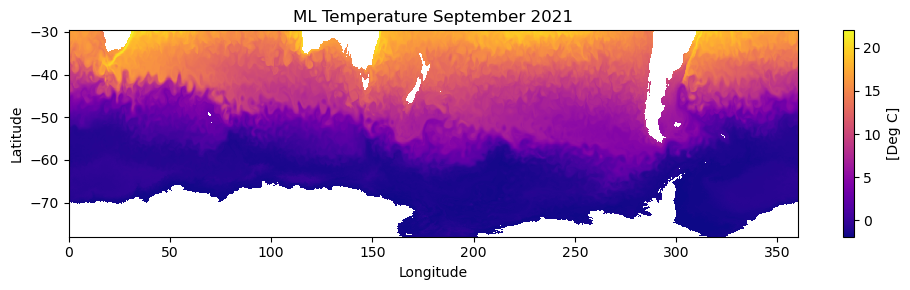

In [86]:
plt.figure()

#ti=97 # feb 2021
ti=104 # sept 2021
#var = theta_ML[ti,:,:]-SST[ti,:,:]
var = theta_ML[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='plasma')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'ML Temperature {time_str}')
plt.tight_layout()

plt.show()

### Gradients in ML temperature

In [87]:
# Find frontal regions for ML temperature

# Get x and y coordinate arrays
x = ds.XC  # shape (nx,)
y = ds.YC  # shape (ny,)

# Compute spacing
dx = np.gradient(x)  # shape (nx,)
dy = np.gradient(y)  # shape (ny,)

# Broadcast dx and dy to match SST shape
DX, DY = np.meshgrid(dx, dy)

# Compute SST gradient
dthetaML_dx = np.gradient(theta_ML, axis=2) / DX
dthetaML_dy = np.gradient(theta_ML, axis=1) / DY

# Gradient magnitude
grad_thetaML = np.sqrt(dthetaML_dx**2 + dthetaML_dy**2)

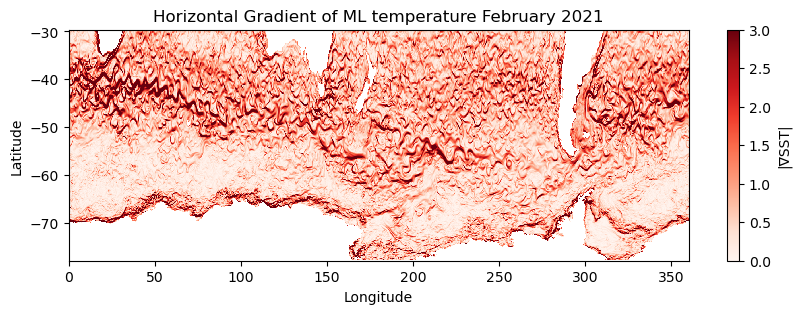

In [88]:
XCc, YCc = np.meshgrid(x, y)

plt.figure()

ti=97 # feb 2021
#ti=104 # sept 2021
time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML[ti,:,:]
#var = grad_thetaML[ti,:,:]-grad_SST[ti,:,:]

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature {time_str}')

plt.show()

### ML temperature gradient climatology

In [89]:
# Wrap gradient array into DataArray
grad_thetaML_da = xr.DataArray(
    grad_thetaML,
    coords={"time": ds.time, "YC": ds.YC, "XC": ds.XC},
    dims=["time", "YC", "XC"]
)

# Group by month and compute climatology (mean for each month)
grad_thetaML_clim = grad_thetaML_da.groupby("time.month").mean("time")

# Replace numeric months (1-12) with abbreviated names ('Jan', 'Feb', ...)
month_names = [calendar.month_abbr[m] for m in grad_thetaML_clim["month"].values]
grad_thetaML_clim = grad_thetaML_clim.assign_coords(month=("month", month_names))

### Winter and summer climatology of ML temperature gradient 

In [90]:
# Winter months: JAS
# Summer months: DJF

grad_thetaML_winter = grad_thetaML_clim.sel(month=["Jul", "Aug", "Sep"]).mean(dim='month')
grad_thetaML_summer = grad_thetaML_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month')

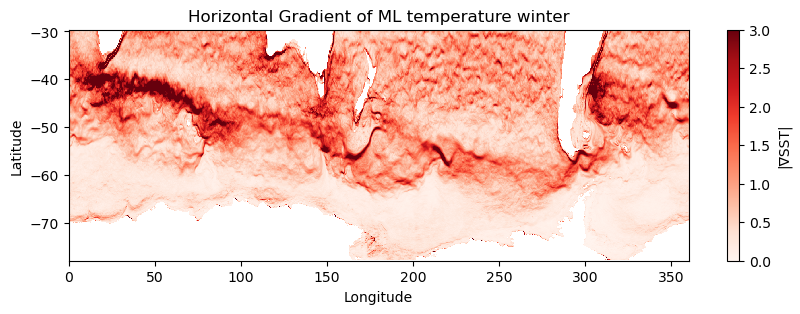

In [92]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML_winter

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature winter')

plt.show()

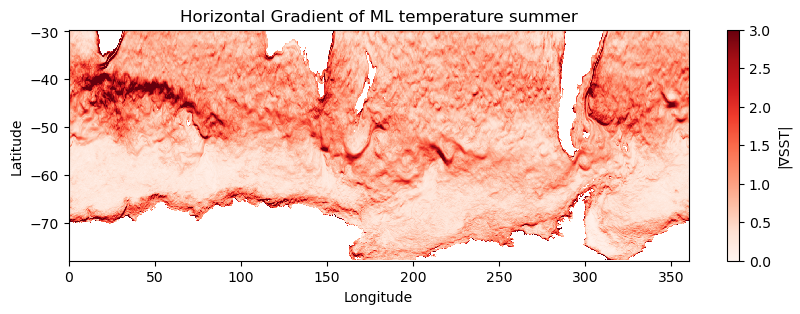

In [93]:
plt.figure()

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

var = grad_thetaML_summer

vmin = 0
vmax = 3
plt.pcolormesh(XCc, YCc, var, shading='auto', vmin=vmin, vmax=vmax, cmap='Reds')
plt.colorbar(label='|∇SST|')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Horizontal Gradient of ML temperature summer')

plt.show()

In [53]:
# Vertical profile of temperature

T_mean_profile = theta_ds.THETA.isel(XC=500).isel(YC=400).mean(dim='time').compute()

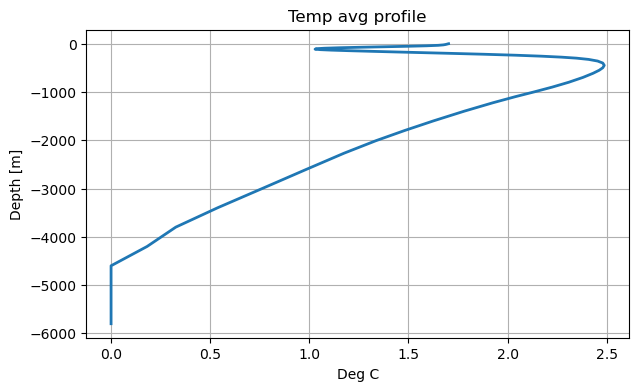

In [54]:
plt.figure(figsize=(7, 4))

plt.ylabel("Depth [m]")
plt.xlabel('Deg C')
plt.grid(True)

plt.gca()
plt.plot(T_mean_profile, theta_ds.Z, linewidth=2) 
plt.title(f"Temp avg profile")

plt.show()

In [55]:
# Vertical profile of temperature avg all domain

T_timemean = theta_ds.THETA.mean(dim='time')

In [58]:
T_domainavg = T_timemean.mean(dim='XC').mean(dim='YC')

In [61]:
T_avg = T_domainavg.compute()

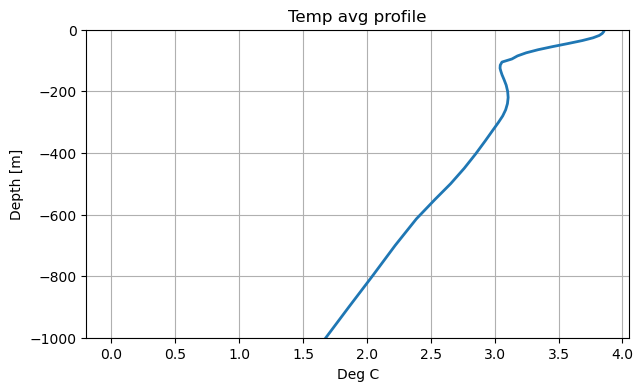

In [63]:
plt.figure(figsize=(7, 4))

plt.ylabel("Depth [m]")
plt.xlabel('Deg C')
plt.grid(True)
plt.ylim(-1000,0)

plt.gca()
plt.plot(T_avg, theta_ds.Z, linewidth=2) 
plt.title(f"Temp avg profile")

plt.show()